In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/de/baseline/experiments/"

In [3]:
files = os.listdir(folder)
len(files)

12

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/12 [00:00<?, ?it/s]

(84, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,2.538,72.197,2.370,68.333,16.463,1.000e-04,0.001,Transformer,110,...,512,4,4,8,relu,0.3,1995729,337,337,22694260_7
1,2,2.431,70.471,2.305,66.763,32.931,1.000e-04,0.001,Transformer,110,...,512,4,4,8,relu,0.3,1995729,337,337,22694260_7
2,3,2.369,69.116,2.270,65.498,49.394,1.000e-04,0.001,Transformer,110,...,512,4,4,8,relu,0.3,1995729,337,337,22694260_7
3,4,2.336,68.283,2.235,64.491,65.800,1.000e-04,0.001,Transformer,110,...,512,4,4,8,relu,0.3,1995729,337,337,22694260_7
4,5,2.313,67.664,2.205,63.755,82.188,1.000e-04,0.001,Transformer,110,...,512,4,4,8,relu,0.3,1995729,337,337,22694260_7


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22694260_1,1.996,0.2,1.000e-04,128,4,114.934,0.370,0.313,7
22694260_10,1.996,0.4,1.000e-02,128,4,119.789,2.676,2.598,2
22694260_11,1.996,0.3,1.000e-03,128,4,116.937,2.268,2.139,7
22694260_12,1.996,0.4,1.000e-02,128,4,116.099,2.592,2.549,7
22694260_2,1.996,0.3,1.000e-03,128,4,120.125,2.214,2.093,7
22694260_3,1.996,0.2,1.000e-03,128,4,117.022,0.890,0.660,7
22694260_4,1.996,0.3,1.000e-04,128,4,115.096,0.417,0.338,7
22694260_5,1.996,0.5,1.000e-03,128,4,115.693,2.359,2.269,7
22694260_6,1.996,0.2,1.000e-04,128,4,122.907,0.380,0.316,7


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/de/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

12

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/12 [00:00<?, ?it/s]

(120, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22694260_5,-224.912,disjoint,greedy,100,4.169,22.845,74.227,NaN
1,22694260_5,-239.210,disjoint,greedy,50,2.075,22.845,77.494,NaN
2,22694260_5,-215.675,disjoint,beam,100,8.937,22.845,72.117,NaN
3,22694260_5,-211.358,disjoint,beam,50,7.713,22.845,71.131,NaN
4,22694260_5,-278.376,sliding,greedy,50,34.080,22.845,86.441,uniform


In [9]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head(10)

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
8,22694260_9,44.008,sliding,beam,50,313.608,22.845,12.792,triangle,1.996,0.3,1.000e-04,128,4,115.779,0.406,0.330,7
9,22694260_6,43.983,sliding,beam,50,303.135,22.845,12.797,bell,1.996,0.2,1.000e-04,128,4,122.907,0.380,0.316,7
9,22694260_9,43.923,sliding,beam,50,314.394,22.845,12.811,bell,1.996,0.3,1.000e-04,128,4,115.779,0.406,0.330,7
7,22694260_9,43.888,sliding,beam,50,317.693,22.845,12.819,uniform,1.996,0.3,1.000e-04,128,4,115.779,0.406,0.330,7
8,22694260_6,43.875,sliding,beam,50,349.709,22.845,12.822,triangle,1.996,0.2,1.000e-04,128,4,122.907,0.380,0.316,7
2,22694260_6,43.677,disjoint,beam,100,10.070,22.845,12.867,NaN,1.996,0.2,1.000e-04,128,4,122.907,0.380,0.316,7
8,22694260_1,43.537,sliding,beam,50,301.955,22.845,12.899,triangle,1.996,0.2,1.000e-04,128,4,114.934,0.370,0.313,7
9,22694260_1,43.518,sliding,beam,50,301.461,22.845,12.903,bell,1.996,0.2,1.000e-04,128,4,114.934,0.370,0.313,7
7,22694260_1,43.358,sliding,beam,50,307.035,22.845,12.940,uniform,1.996,0.2,1.000e-04,128,4,114.934,0.370,0.313,7
7,22694260_6,43.035,sliding,beam,50,361.719,22.845,13.014,uniform,1.996,0.2,1.000e-04,128,4,122.907,0.380,0.316,7


<AxesSubplot:>

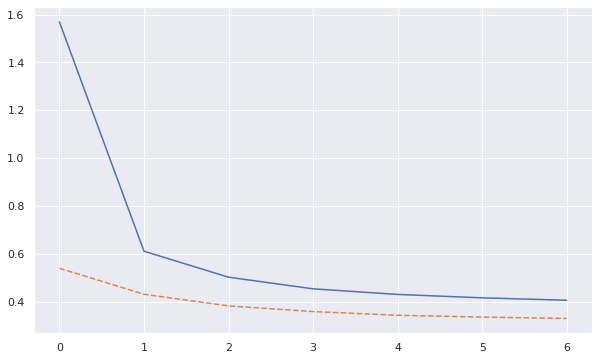

In [10]:
logs.query("experiment_id == '22694260_9'").train_loss.plot()
logs.query("experiment_id == '22694260_9'").dev_loss.plot(ls = "--")

In [11]:
results.query("experiment_id == '22694260_9'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                        sliding                   \
window_size        50             100             50                     
decoding          beam greedy    beam  greedy    beam                    
weighting          NaN    NaN     NaN     NaN    bell triangle uniform   
experiment_id                                                            
22694260_9      38.604  36.13  40.968  39.297  43.923   44.008  43.888   

window                                  
window_size                             
decoding       greedy                   
weighting        bell triangle uniform  
experiment_id                           
22694260_9     41.833   41.815  41.816